<a href="https://colab.research.google.com/github/gani0325/2022/blob/main/kaggle/superresolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022-01-27

### Low resolution images to high resolution
 - kaggle
* https://www.kaggle.com/theblackmamba31/low-resolution-images-to-high-resolution 참고

#### 1. libraires import

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm   # dataloader 을 통해 data를 download 할 때, 상태바 넣어두기 (상태 진행 보여주기)
import re
import matplotlib.pyplot as plt

from keras import layers

#### 2. load data

In [ ]:
def sorted_alphanumeric(data):
    # isdigit() : 문자열이 숫자로 구성되어 있는지 판별
    convert = lambda text : int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key : [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key = alphanum_key)

SIZE = 256
high_img = []
path = 'dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)


for i in tqdm(files) :
    if i == '855.jpg' :
        break
    else :
        img = cv2.imread(path + '/' + i, 1)
        # open bgr to rgb
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # resize
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float') / 255.0
        high_img.append(img_to_array(img))

    
    low_img = []
    path = "dataset/Raw Data/low_res"
    files = os.listdir(path)
    files = sorted_alphanumeric(files)

for i in tqdm(files) :
    if i == "855.jpg" :
        break
    else :
        img = cv2.imread(path + '/' + i, 1)
        # resize
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype("float32") / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:02<00:00, 325.75it/s]


#### 3. Data Visualization

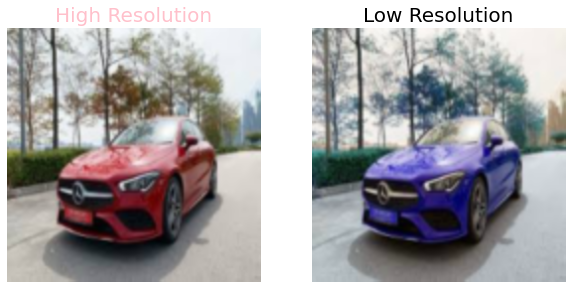

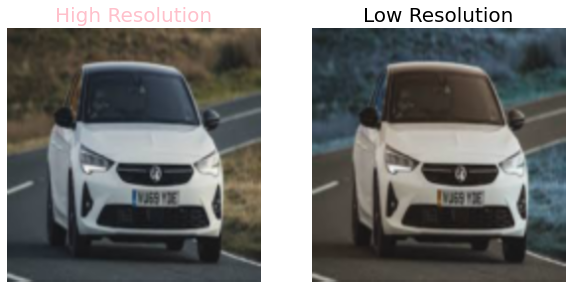

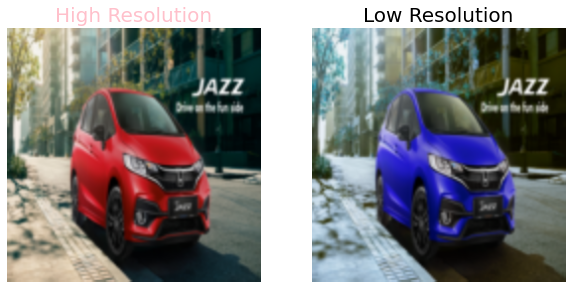

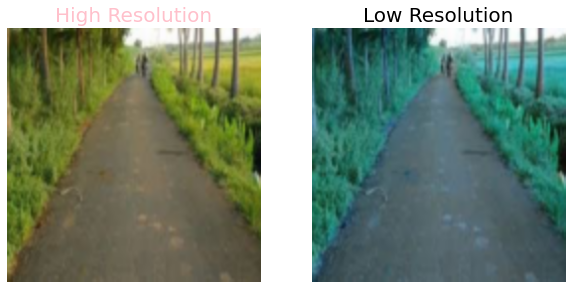

In [ ]:
for i in range(4) :
    a = np.random.randint(0, 855)
    plt.figure(figsize=(10, 10,))

    plt.subplot(1,2,1)
    plt.title("High Resolution", color = "pink", fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.title("Low Resolution", color = "black", fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis("off")

* 왜 high도 화질이 별로지 색깔은 괜찮은데

#### 4. slicing & reshaping images

* train

In [ ]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]

train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

print(train_high_image.shape)
print(train_low_image.shape)

(700, 256, 256, 3)
(700, 256, 256, 3)


* validation

In [ ]:
validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]

validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))

print(validation_high_image.shape)
print(validation_low_image.shape)

(130, 256, 256, 3)
(130, 256, 256, 3)


* test

In [ ]:
test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print(test_high_image.shape)
print(test_low_image.shape)

(25, 256, 256, 3)
(25, 256, 256, 3)


In [ ]:
print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


#### 5. Model

In [ ]:
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

In [ ]:
def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [ ]:
def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  147584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  296192      sequential_1[0][0]               
______________________________________________________________________________________________

#### 6. 컴파일

In [ ]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001),
    loss = "mean_absolute_error",
    metrics = ['acc'])

#### 7. fitting model

In [ ]:
model.fit(train_low_image, train_high_image, epochs=7,  batch_size= 1,
    validation_data = (validation_low_image, validation_high_image))

Epoch 1/7
700/700 [==============================] - 540s 766ms/step - loss: 0.0384 - acc: 0.6364 - val_loss: 0.0497 - val_acc: 0.4085
Epoch 2/7
700/700 [==============================] - 467s 666ms/step - loss: 0.0111 - acc: 0.8040 - val_loss: 0.0071 - val_acc: 0.8447
Epoch 3/7
700/700 [==============================] - 406s 580ms/step - loss: 0.0078 - acc: 0.8291 - val_loss: 0.0090 - val_acc: 0.9189
Epoch 4/7
700/700 [==============================] - 377s 538ms/step - loss: 0.0067 - acc: 0.8437 - val_loss: 0.0085 - val_acc: 0.8032
Epoch 5/7
700/700 [==============================] - 556s 794ms/step - loss: 0.0063 - acc: 0.8494 - val_loss: 0.0049 - val_acc: 0.8522
Epoch 6/7
700/700 [==============================] - 547s 779ms/step - loss: 0.0059 - acc: 0.8502 - val_loss: 0.0063 - val_acc: 0.8047
Epoch 7/7
700/700 [==============================] - 319s 456ms/step - loss: 0.0053 - acc: 0.8702 - val_loss: 0.0060 - val_acc: 0.8673


#### 8. 예측 시각화

In [ ]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))

    plt.subplot(1,3,1)
    plt.title('High Image', color = 'pink', fontsize = 20)
    plt.imshow(high)

    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'orange', fontsize = 20)
    plt.imshow(low)

    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'green', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

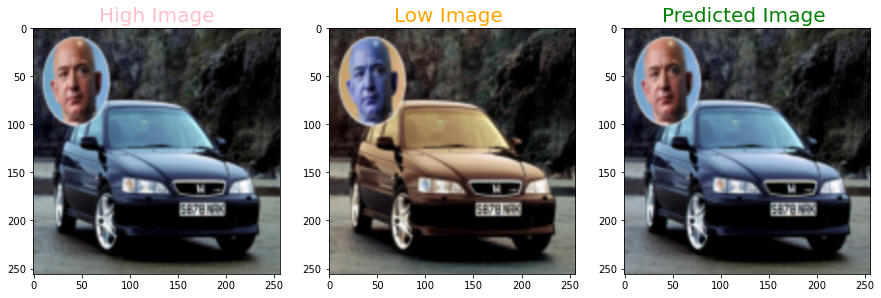

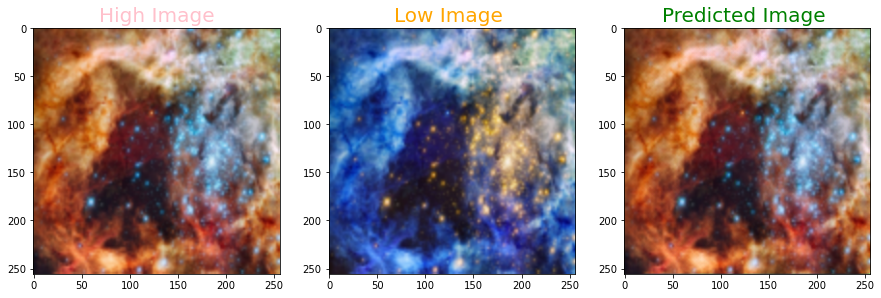

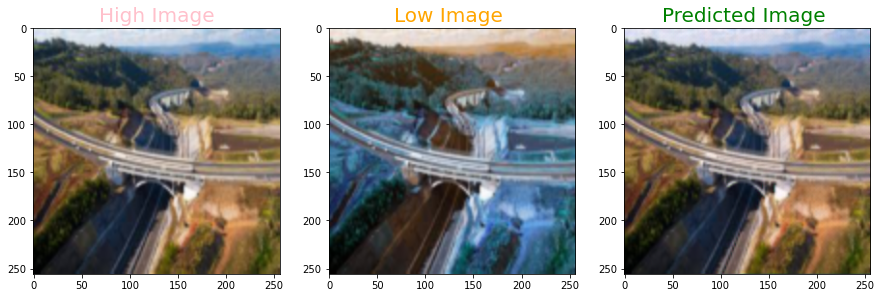

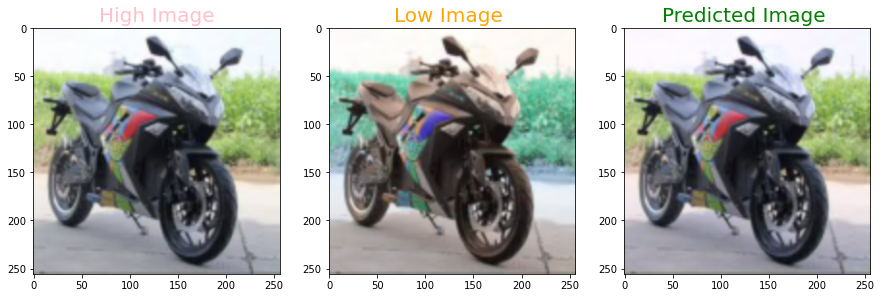

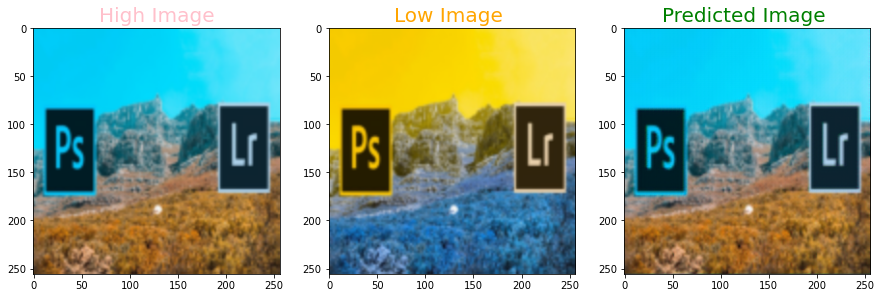

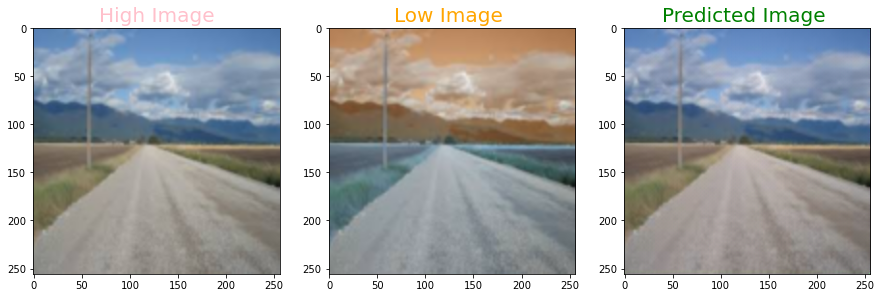

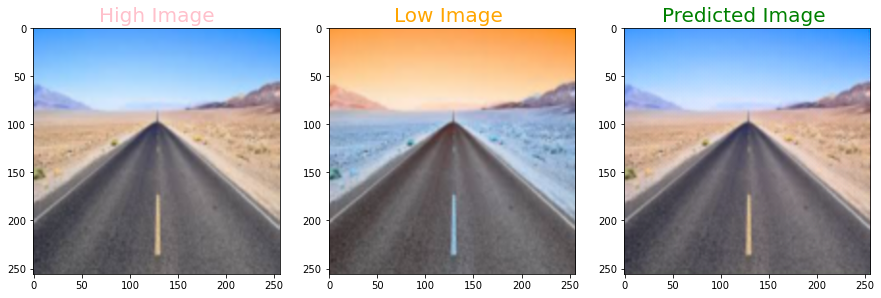

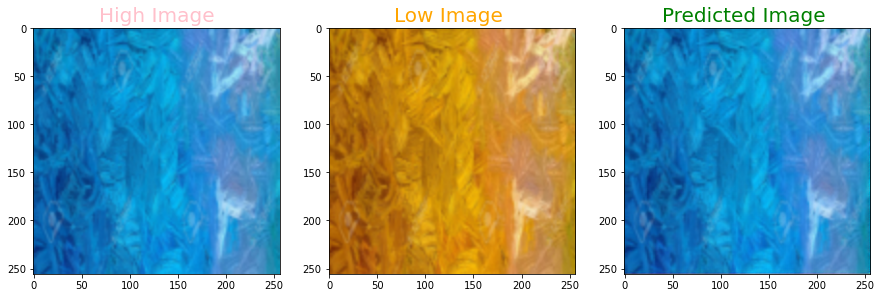

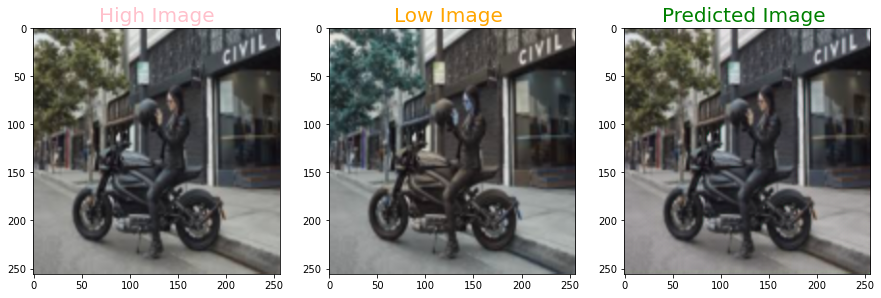

In [ ]:
for i in range(1,10):
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)